In [1]:
!pip install timm torchsummary tqdm grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.1 MB/s 
     |████████████████████████████████| 16.8 MB 34.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.9-py3-none-any.whl size=25984 sha256=fc07c0094955ee02eab7d216847219d80ac960b3eeaeb8d49ca47d64d5b2a145
  Stored in directory: /root/.cache/pip/wheels/65/e8/6e/6eedfbe3f0007dfd8116e6820b69691c4103d89ad2ae8c69ff
Successfully built grad-cam


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
!git clone https://github.com/jacobgil/vit-explain vit_explain

Cloning into 'vit_explain'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 96 (delta 36), reused 75 (delta 19), pack-reused 0
Unpacking objects: 100% (96/96), done.


In [5]:
from vit_explain.vit_rollout import VITAttentionRollout
from vit_explain.vit_grad_rollout import VITAttentionGradRollout

## Setting up the GPU/CPU
will depend on the selected runtime for colab

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Loading images to check

In [7]:
test_image_path_1  = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/436219-7159-48987-[1, 1, 0].png'
test_image_path_2  = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/cutmix_augmentation/0000-[0, 1, 1].png'
valid_image_path   = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/img/00.png'
valid_mask_path    = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/2.validation/2.validation/mask/00.png'

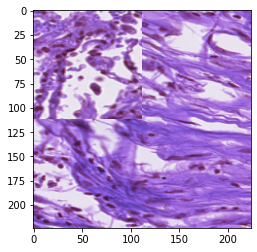

In [9]:
img = cv2.imread(test_image_path_2)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [10]:
test_image_1 = cv2.imread(test_image_path_1)
test_image_1 = cv2.resize(test_image_1, (224, 224))

test_image_2 = cv2.imread(test_image_path_2)
test_image_2 = cv2.resize(test_image_2, (224, 224))

valid_image  = cv2.imread(valid_image_path)
valid_image  = cv2.resize(valid_image, (224, 224))

valid_mask   = cv2.imread(valid_mask_path)
valid_mask   = cv2.resize(valid_mask, (224, 224))

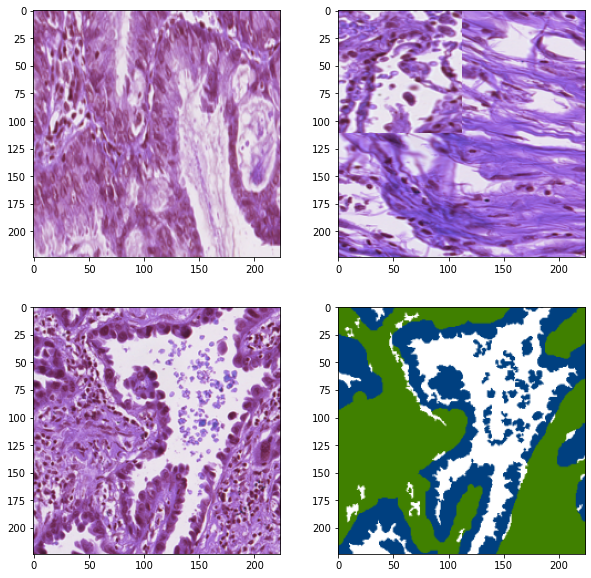

In [11]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(test_image_2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [12]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize(resized),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)

In [13]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    mask = cv2.resize(mask, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Creating models

## Vit 32 01

In [ ]:
cutmix_model_vit_base_patch32_224_01 = timm.create_model('vit_base_patch32_224', pretrained = True, num_classes = 3,
                                                         drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

cutmix_model_vit_base_patch32_224_01.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch32_224_01.pth',
                                                      map_location=torch.device(device)))

cutmix_model_vit_base_patch32_224_01.eval()

## Vit 32 02

In [ ]:
cutmix_model_vit_base_patch32_224_02 = timm.create_model('vit_base_patch32_224', pretrained = True, num_classes = 3,
                                                         drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

cutmix_model_vit_base_patch32_224_02.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch32_224_02.pth',
                                                      map_location=torch.device(device)))

cutmix_model_vit_base_patch32_224_02.eval()

## Vit 16 01

In [ ]:
cutmix_model_vit_base_patch16_224_01 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                                         drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

cutmix_model_vit_base_patch16_224_01.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch16_224_01.pth',
                                                      map_location=torch.device(device)))

cutmix_model_vit_base_patch16_224_01.eval()

## Deit 16 01

In [ ]:
cutmix_model_deit_base_patch16_224_01 = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', num_classes=3,
                                                      drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

cutmix_model_deit_base_patch16_224_01.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_deit_base_patch16_224_01.pth',
                                                      map_location=torch.device(device)))

cutmix_model_deit_base_patch16_224_01.eval()

## Deit 16 02

In [ ]:
cutmix_model_deit_base_patch16_224_02 = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', num_classes=3,
                                                      drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

cutmix_model_deit_base_patch16_224_02.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_deit_base_patch16_224_02.pth',
                                                      map_location=torch.device(device)))

cutmix_model_deit_base_patch16_224_02.eval()

## Deit 16 03

In [ ]:
cutmix_model_deit_base_patch16_224_03 = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', num_classes=3,
                                                      drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

cutmix_model_deit_base_patch16_224_03.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_deit_base_patch16_224_03.pth',
                                                      map_location=torch.device(device)))

cutmix_model_deit_base_patch16_224_03.eval()

# Configuring images

In [20]:
test_image_1_tensor = preprocess_image(test_image_1).to(device)
test_image_2_tensor = preprocess_image(test_image_2).to(device)
valid_image_tensor  = preprocess_image(valid_image).to(device)

# Rollout Attention

## Model 1

In [85]:
attention_rollout_min = VITAttentionRollout(cutmix_model_vit_base_patch32_224_01, head_fusion='min',
                                        discard_ratio=0.9)

attention_rollout_mean = VITAttentionRollout(cutmix_model_vit_base_patch32_224_01, head_fusion='mean',
                                        discard_ratio=0.9)

attention_rollout_max = VITAttentionRollout(cutmix_model_vit_base_patch32_224_01, head_fusion='max',
                                        discard_ratio=0.9)

In [86]:
mask_min_1 = attention_rollout_min(test_image_1_tensor)
mask_min_2 = attention_rollout_min(test_image_2_tensor)
mask_min_3 = attention_rollout_min(valid_image_tensor)

In [87]:
mask_mean_1 = attention_rollout_mean(test_image_1_tensor)
mask_mean_2 = attention_rollout_mean(test_image_2_tensor)
mask_mean_3 = attention_rollout_mean(valid_image_tensor)

In [88]:
mask_max_1 = attention_rollout_max(test_image_1_tensor)
mask_max_2 = attention_rollout_max(test_image_2_tensor)
mask_max_3 = attention_rollout_max(valid_image_tensor)

In [89]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 2

In [90]:
attention_rollout_min = VITAttentionRollout(cutmix_model_vit_base_patch32_224_02, head_fusion='min',
                                        discard_ratio=0.9)

attention_rollout_mean = VITAttentionRollout(cutmix_model_vit_base_patch32_224_02, head_fusion='mean',
                                        discard_ratio=0.9)

attention_rollout_max = VITAttentionRollout(cutmix_model_vit_base_patch32_224_02, head_fusion='max',
                                        discard_ratio=0.9)

In [91]:
mask_min_1 = attention_rollout_min(test_image_1_tensor)
mask_min_2 = attention_rollout_min(test_image_2_tensor)
mask_min_3 = attention_rollout_min(valid_image_tensor)

In [92]:
mask_mean_1 = attention_rollout_mean(test_image_1_tensor)
mask_mean_2 = attention_rollout_mean(test_image_2_tensor)
mask_mean_3 = attention_rollout_mean(valid_image_tensor)

In [93]:
mask_max_1 = attention_rollout_max(test_image_1_tensor)
mask_max_2 = attention_rollout_max(test_image_2_tensor)
mask_max_3 = attention_rollout_max(valid_image_tensor)

In [94]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 3

In [95]:
attention_rollout_min = VITAttentionRollout(cutmix_model_vit_base_patch16_224_01, head_fusion='min',
                                        discard_ratio=0.9)

attention_rollout_mean = VITAttentionRollout(cutmix_model_vit_base_patch16_224_01, head_fusion='mean',
                                        discard_ratio=0.9)

attention_rollout_max = VITAttentionRollout(cutmix_model_vit_base_patch16_224_01, head_fusion='max',
                                        discard_ratio=0.9)

In [96]:
mask_min_1 = attention_rollout_min(test_image_1_tensor)
mask_min_2 = attention_rollout_min(test_image_2_tensor)
mask_min_3 = attention_rollout_min(valid_image_tensor)

In [97]:
mask_mean_1 = attention_rollout_mean(test_image_1_tensor)
mask_mean_2 = attention_rollout_mean(test_image_2_tensor)
mask_mean_3 = attention_rollout_mean(valid_image_tensor)

In [98]:
mask_max_1 = attention_rollout_max(test_image_1_tensor)
mask_max_2 = attention_rollout_max(test_image_2_tensor)
mask_max_3 = attention_rollout_max(valid_image_tensor)

In [99]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 4

In [100]:
attention_rollout_min = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='min',
                                        discard_ratio=0.9)

attention_rollout_mean = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='mean',
                                        discard_ratio=0.9)

attention_rollout_max = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='max',
                                        discard_ratio=0.9)

In [101]:
mask_min_1 = attention_rollout_min(test_image_1_tensor)
mask_min_2 = attention_rollout_min(test_image_2_tensor)
mask_min_3 = attention_rollout_min(valid_image_tensor)

In [102]:
mask_mean_1 = attention_rollout_mean(test_image_1_tensor)
mask_mean_2 = attention_rollout_mean(test_image_2_tensor)
mask_mean_3 = attention_rollout_mean(valid_image_tensor)

In [103]:
mask_max_1 = attention_rollout_max(test_image_1_tensor)
mask_max_2 = attention_rollout_max(test_image_2_tensor)
mask_max_3 = attention_rollout_max(valid_image_tensor)

In [104]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 5

In [105]:
attention_rollout_min = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='min',
                                        discard_ratio=0.9)

attention_rollout_mean = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='mean',
                                        discard_ratio=0.9)

attention_rollout_max = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='max',
                                        discard_ratio=0.9)

In [106]:
mask_min_1 = attention_rollout_min(test_image_1_tensor)
mask_min_2 = attention_rollout_min(test_image_2_tensor)
mask_min_3 = attention_rollout_min(valid_image_tensor)

In [107]:
mask_mean_1 = attention_rollout_mean(test_image_1_tensor)
mask_mean_2 = attention_rollout_mean(test_image_2_tensor)
mask_mean_3 = attention_rollout_mean(valid_image_tensor)

In [108]:
mask_max_1 = attention_rollout_max(test_image_1_tensor)
mask_max_2 = attention_rollout_max(test_image_2_tensor)
mask_max_3 = attention_rollout_max(valid_image_tensor)

In [109]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 6

In [110]:
attention_rollout_min = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='min',
                                        discard_ratio=0.9)

attention_rollout_mean = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='mean',
                                        discard_ratio=0.9)

attention_rollout_max = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='max',
                                        discard_ratio=0.9)

In [111]:
mask_min_1 = attention_rollout_min(test_image_1_tensor)
mask_min_2 = attention_rollout_min(test_image_2_tensor)
mask_min_3 = attention_rollout_min(valid_image_tensor)

In [112]:
mask_mean_1 = attention_rollout_mean(test_image_1_tensor)
mask_mean_2 = attention_rollout_mean(test_image_2_tensor)
mask_mean_3 = attention_rollout_mean(valid_image_tensor)

In [113]:
mask_max_1 = attention_rollout_max(test_image_1_tensor)
mask_max_2 = attention_rollout_max(test_image_2_tensor)
mask_max_3 = attention_rollout_max(valid_image_tensor)

In [114]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

# Grad Rollout

## Model 1

In [115]:
attention_rollout = VITAttentionGradRollout(cutmix_model_vit_base_patch32_224_01, discard_ratio=0.9)

In [116]:
mask_min_1 = attention_rollout(test_image_1_tensor, 0)
mask_min_2 = attention_rollout(test_image_2_tensor, 0)
mask_min_3 = attention_rollout(valid_image_tensor, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
mask_mean_1 = attention_rollout(test_image_1_tensor, 1)
mask_mean_2 = attention_rollout(test_image_2_tensor, 1)
mask_mean_3 = attention_rollout(valid_image_tensor, 1)

In [117]:
mask_max_1 = attention_rollout(test_image_1_tensor, 2)
mask_max_2 = attention_rollout(test_image_2_tensor, 2)
mask_max_3 = attention_rollout(valid_image_tensor, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [118]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 2

In [119]:
attention_rollout = VITAttentionGradRollout(cutmix_model_vit_base_patch32_224_02, discard_ratio=0.9)

In [120]:
mask_min_1 = attention_rollout(test_image_1_tensor, 0)
mask_min_2 = attention_rollout(test_image_2_tensor, 0)
mask_min_3 = attention_rollout(valid_image_tensor, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [121]:
mask_mean_1 = attention_rollout(test_image_1_tensor, 1)
mask_mean_2 = attention_rollout(test_image_2_tensor, 1)
mask_mean_3 = attention_rollout(valid_image_tensor, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [122]:
mask_max_1 = attention_rollout(test_image_1_tensor, 2)
mask_max_2 = attention_rollout(test_image_2_tensor, 2)
mask_max_3 = attention_rollout(valid_image_tensor, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [123]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 3

In [124]:
attention_rollout = VITAttentionGradRollout(cutmix_model_vit_base_patch16_224_01, discard_ratio=0.9)

In [125]:
mask_min_1 = attention_rollout(test_image_1_tensor, 0)
mask_min_2 = attention_rollout(test_image_2_tensor, 0)
mask_min_3 = attention_rollout(valid_image_tensor, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [126]:
mask_mean_1 = attention_rollout(test_image_1_tensor, 1)
mask_mean_2 = attention_rollout(test_image_2_tensor, 1)
mask_mean_3 = attention_rollout(valid_image_tensor, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [127]:
mask_max_1 = attention_rollout(test_image_1_tensor, 2)
mask_max_2 = attention_rollout(test_image_2_tensor, 2)
mask_max_3 = attention_rollout(valid_image_tensor, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [128]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 4

In [129]:
attention_rollout = VITAttentionGradRollout(cutmix_model_deit_base_patch16_224_01, discard_ratio=0.9)

In [130]:
mask_min_1 = attention_rollout(test_image_1_tensor, 0)
mask_min_2 = attention_rollout(test_image_2_tensor, 0)
mask_min_3 = attention_rollout(valid_image_tensor, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [131]:
mask_mean_1 = attention_rollout(test_image_1_tensor, 1)
mask_mean_2 = attention_rollout(test_image_2_tensor, 1)
mask_mean_3 = attention_rollout(valid_image_tensor, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [132]:
mask_max_1 = attention_rollout(test_image_1_tensor, 2)
mask_max_2 = attention_rollout(test_image_2_tensor, 2)
mask_max_3 = attention_rollout(valid_image_tensor, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [133]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 5

In [134]:
attention_rollout = VITAttentionGradRollout(cutmix_model_deit_base_patch16_224_01, discard_ratio=0.9)

In [135]:
mask_min_1 = attention_rollout(test_image_1_tensor, 0)
mask_min_2 = attention_rollout(test_image_2_tensor, 0)
mask_min_3 = attention_rollout(valid_image_tensor, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [136]:
mask_mean_1 = attention_rollout(test_image_1_tensor, 1)
mask_mean_2 = attention_rollout(test_image_2_tensor, 1)
mask_mean_3 = attention_rollout(valid_image_tensor, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [137]:
mask_max_1 = attention_rollout(test_image_1_tensor, 2)
mask_max_2 = attention_rollout(test_image_2_tensor, 2)
mask_max_3 = attention_rollout(valid_image_tensor, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [138]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

## Model 6

In [139]:
attention_rollout = VITAttentionGradRollout(cutmix_model_deit_base_patch16_224_01, discard_ratio=0.9)

In [140]:
mask_min_1 = attention_rollout(test_image_1_tensor, 0)
mask_min_2 = attention_rollout(test_image_2_tensor, 0)
mask_min_3 = attention_rollout(valid_image_tensor, 0)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [141]:
mask_mean_1 = attention_rollout(test_image_1_tensor, 1)
mask_mean_2 = attention_rollout(test_image_2_tensor, 1)
mask_mean_3 = attention_rollout(valid_image_tensor, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [142]:
mask_max_1 = attention_rollout(test_image_1_tensor, 2)
mask_max_2 = attention_rollout(test_image_2_tensor, 2)
mask_max_3 = attention_rollout(valid_image_tensor, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [143]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(3, 3, 1)
plt.imshow(show_mask_on_image(test_image_1, mask_min_1))

ax = fig.add_subplot(3, 3, 2)
plt.imshow(show_mask_on_image(test_image_2, mask_min_2))

ax = fig.add_subplot(3, 3, 3)
plt.imshow(show_mask_on_image(valid_image, mask_min_3))

ax = fig.add_subplot(3, 3, 4)
plt.imshow(show_mask_on_image(test_image_1, mask_mean_1))

ax = fig.add_subplot(3, 3, 5)
plt.imshow(show_mask_on_image(test_image_2, mask_mean_2))

ax = fig.add_subplot(3, 3, 6)
plt.imshow(show_mask_on_image(valid_image, mask_mean_3))

ax = fig.add_subplot(3, 3, 7)
plt.imshow(show_mask_on_image(test_image_1, mask_max_1))

ax = fig.add_subplot(3, 3, 8)
plt.imshow(show_mask_on_image(test_image_2, mask_max_2))

ax = fig.add_subplot(3, 3, 9)
plt.imshow(show_mask_on_image(valid_image, mask_max_3))

Output hidden; open in https://colab.research.google.com to view.

# Testing Attention Rollout

## Test 1 - Succes (cam needs to be reshaped)

In [ ]:
np_img = np.array(img)[:, :, ::-1]

In [ ]:
np_img.shape

In [ ]:
np_img_tensor = preprocess_image(np_img)

In [ ]:
attention_rollout = VITAttentionRollout(deit_test, head_fusion='max',
                                        discard_ratio=0.9)

In [ ]:
mask = attention_rollout(np_img_tensor)

In [ ]:
cam = show_mask_on_image(np_img, mask)    # ----> cv2.resize(mask, (224, 224)) moved to insode the function

In [ ]:
plt.imshow(cam)

## Test 2 - Trained Model

In [ ]:
attention_rollout = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='min',
                                        discard_ratio=0.9)

In [ ]:
mask = attention_rollout(np_img_tensor)
cam = show_mask_on_image(np_img, mask) 

plt.imshow(cam)

## Valid Image

In [ ]:
attention_rollout = VITAttentionRollout(cutmix_model_deit_base_patch16_224_01, head_fusion='max',
                                        discard_ratio=0.9)

In [ ]:
mask = attention_rollout(valid_image_tensor)
cam = show_mask_on_image(valid_image, mask) 

plt.imshow(cam)

# Trying Attention Grad Rollout 

## Native Model

In [ ]:
grad_rollout = VITAttentionGradRollout(deit_test, discard_ratio=0.9)

In [ ]:
mask = grad_rollout(np_img_tensor, 1)
cam = show_mask_on_image(np_img, mask) 

plt.imshow(cam)

## Trained Model

In [ ]:
grad_rollout = VITAttentionGradRollout(cutmix_model_deit_base_patch16_224_01, discard_ratio=0.9)

In [ ]:
mask = grad_rollout(np_img_tensor, 2)
cam = show_mask_on_image(np_img, mask) 

plt.imshow(cam)

## Valid Image

In [18]:
grad_rollout = VITAttentionGradRollout(cutmix_model_deit_base_patch16_224_01, discard_ratio=0.5)

In [19]:
mask = grad_rollout(valid_image_tensor, 3)
cam = show_mask_on_image(valid_image, mask) 

plt.imshow(cam)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


IndexError: ignored